# Stellar mass estimation for the GLADE+ galaxies

This notebook contains the stellar mass estimation for the GLADE+ galaxies with two different methods, the comparison of them, some other analysis and the calculation of the merger rate of compact binaries based on the stellar mass.

The code was written by Mária Pálfi (marika97@caesar.elte.hu).

In [1]:
# importing useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
from scipy.optimize import curve_fit
import seaborn as sns
plt.style.use('seaborn-white') # set figure style

# Reading the catalog

This catalog was created by the *create_working_catalog.ipynb*.

In [2]:
# reading the file to 'data' pandas dataframe
data = pd.read_csv( 'data_for_work.txt', delimiter = '\t', low_memory = False )
print( 'dataframe with the necessary columns:\n' )
data

dataframe with the necessary columns:



,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W1_err,z,flag,z_err,lumdis,lumdis_err,gal_type,num
0,NGC4736,NGC4736,12505314+4107125,J125053.14+410712.7,G,192.721451,41.120152,5.611000,NaN,0.000991,0.0,0.000029,4.392418,0.127479,1.0,0.0
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416000,NaN,0.004120,1.0,0.000119,15.876007,0.532731,1.0,1.0
2,NGC6503,NGC6503,17492651+7008396,J174926.45+700840.8,G,267.360474,70.144341,10.180000,NaN,0.001000,1.0,0.000029,12.446600,0.128670,1.0,2.0
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476000,NaN,0.003557,1.0,0.000103,11.461371,0.459550,0.0,3.0
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784000,NaN,0.004139,1.0,0.000120,15.180920,0.535217,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23181753,NaN,NaN,NaN,NaN,Q,359.999118,28.954734,17.728901,NaN,2.452000,0.0,0.113916,20403.464630,1152.204222,NaN,NaN
23181754,NaN,NaN,NaN,NaN,Q,359.999303,34.720842,16.933657,NaN,3.109000,0.0,0.135597,27158.368406,1423.972156,NaN,NaN
23181755,NaN,NaN,NaN,NaN,Q,359.999615,3.268586,14.833991,NaN,1.232962,0.0,0.073688,8792.439985,652.241875,NaN,NaN
23181756,NaN,NaN,NaN,NaN,Q,359.999759,20.721079,16.979166,NaN,2.009865,0.0,0.099325,16022.500633,970.465889,NaN,NaN


In [3]:
data.columns

Index(['GWGC', 'Hyp', '2MASS', 'wiseX', 'type', 'ra', 'dec', 'W1', 'W1_err',
       'z', 'flag', 'z_err', 'lumdis', 'lumdis_err', 'gal_type', 'num'],
      dtype='object')

## Filtration

In [4]:
# We need only the galaxies, therefore we filtrate the quasars ('Q'):
data_new = copy.deepcopy( data[ data.type != 'Q' ] )
print('Length with galaxies only:', data_new.shape[0])
# we need galaxies having luminosity distance:
data_new = data_new[ ~np.isnan(data_new.lumdis) ] 
print( 'Length with known luminosty distance:', data_new.shape[0])
# Kettlety et al. also filtrated the z < 0.003 galaxies,
# because they may be stellar contamintaion.
data_new = data_new[data_new.z > 0.003 ]
print( 'Number of galaxies with z < 0.003:', len( data_new ))
# We need the WISE magnitude (from the original dataframe):
data_new = data_new[ ~np.isnan(data_new.W1) ]
print('Length with W1:', data_new.shape[0])

Length with galaxies only: 22431348
Length with known luminosty distance: 21884742
Number of galaxies with z < 0.003: 21880292
Length with W1: 21779322


In [5]:
print( 'Galaxies with known luminosity distance error:', len(data_new[~np.isnan(data_new.lumdis_err)]) )

Galaxies with known luminosity distance error: 21779082


Passive (elliptical) galaxies:

In [6]:
len( data_new[ data_new.gal_type == 0 ] )

799703

Active (spiral) galaxies:

In [7]:
len( data_new[ data_new.gal_type == 1 ] )

18351034

There are galaxies having no type:

In [8]:
len( data_new[ np.isnan( data_new.gal_type ) ] )

2628585

## Estimaing the stellar mass via Kettlety's method
Kettlety et al. 2018. (MNRAS 473, 776–783 (2018), doi:10.1093/mnras/stx2379)

### For passive galaxies:
$$M_*/L_{W1} = 0.65 \pm 0.07$$

$$M_* = 0.65 \cdot L_{W1}$$

This is best for z $\leq$ 0.15.

$$L_{W1} (L_{Sun}) = 10^{−0.4(M −M_{Sun} )},$$  

$$M_{Sun} = 3.24$$ 

$M$ is the absolute magnitude measured in the W1 filter.

(It was first published in Norris et al. (2014) (Norris M. A., Meidt S., van de Ven G., Schinnerer E, Groves B., Querejeta M., 2014, ApJ, 797, 55).)

I calculate the absolute magnitude:

$$m-M = -5+5 \lg d,$$ 

$$M = m+5-5 \lg d,$$

where $m$ is the apparent magnitude, $d$ is the distance (luminosity distance).

#### K correction
With the K correction of the absolute magnitude we can take into account the shifting of the band because of the expansion of the Universe. This means that we measure the light emitted in 'x' band in 'y' band. 

According to Hogg et al. 2002. (https://arxiv.org/abs/astro-ph/0210394):

$$m_R = M_Q + DM + K_{QR},$$

where $m_R$ is the apparent magnitude measured in band $R$, $M_Q$ is the absolute magnitude emitted in band $Q$, $K_{QR}$ is the K correction and DM is the distance modulus:

$$DM = 5 \cdot \lg \frac{D_L}{10 ~pc},$$

where $D_L$ is the luminosity distance.

In Kettlety et al. 2018.:

$$K_ {W1} = - 7.1 \lg( 1 + z )$$

The **stellar mass** can be calculated from the WISE W1 magnitude (m) as:
$$M_* = 0.65 \cdot 10^{-0.4[m+5-5\lg d + 7.1\lg(1+z)-3.24]}$$


### For active galaxies:
$$ \lg(M_*/L_{W1}) = -0.4 \pm 0.2$$

$$ M_* = 10^{-0.4} \cdot L_{W1}$$


### The uncertainty:
$$\Delta M_*(a,m,d,z) = M_* \cdot \sqrt{ \left(\frac{\Delta a}{a} \right)^2 + |0.4 \cdot \ln(10)|^2 \cdot \Delta m^2+4\cdot \left( \frac{\Delta d}{d}\right)^2 + (0.4\cdot 0.71)^2 \cdot \left( \frac{\Delta z}{|1+z|}\right)^2},$$
where $\Delta a = 0.07$.

In [9]:
# absolute magnitude in the W1 band without K correction:
M1_wKc = data_new.W1 + 5 - 5 * np.log10( data_new.lumdis*1e6 )
print( 'absolute magnitude in the W1 band without K correction:' )
print( M1_wKc[:5] )

# K correction for W1 magnitudes according to Kettlety:
M1_Kettlety = M1_wKc + 7.1 * np.log10(1+data_new.z) 
print( '\nK corrected absolute W1 magnitudes according to Kettlety:' )
print( M1_Kettlety[:5] )

# W1 band luminosity:
M_sun = 3.24
print( '\n$L_{W1}$ luminosity:' )
L_W1_Kettlety = 10**( -0.4 * ( M1_Kettlety - M_sun ) )
print( L_W1_Kettlety[:5] )

absolute magnitude in the W1 band without K correction:
1   -21.587706
3   -21.820183
4   -21.122490
5   -20.092803
6   -21.407693
dtype: float64

K corrected absolute W1 magnitudes according to Kettlety:
1   -21.575030
3   -21.809235
4   -21.109755
5   -20.082583
6   -21.394339
dtype: float64

$L_{W1}$ luminosity:
1    8.433579e+09
3    1.046391e+10
4    5.494170e+09
5    2.133208e+09
6    7.140614e+09
dtype: float64


In [10]:
filt_passive = data_new.gal_type == 0
filt_active = data_new.gal_type != 0

In [11]:
# stellar mass for passive galaxies:
M_Kettlety = 0.65*L_W1_Kettlety[ filt_passive ]
# stellar mass for active galaxies:
M_Kettlety_active = 10**(-0.4)*L_W1_Kettlety[ filt_active ]
M_Kettlety = pd.concat( [ M_Kettlety, M_Kettlety_active ] )
data_new[ 'sm' ] = M_Kettlety

In [12]:
# Is there any too small stellar mass?
np.sum( data_new.sm < 1e5 )

0

## Function for error propagation with correlation

We approximate the error with the standard deviation, $\sigma_f$, calculated from 

$$\sigma_f^2 \approx \sum_{i=1}^n \left|\frac{\partial f}{\partial x_i}\right|^2 \sigma_i^2 + 2 \cdot \sum_{j=1}^n \sum_{k>j}^n \frac{\partial f}{\partial x_j} \frac{\partial f}{\partial x_k} \sigma_j \sigma_k \rho_{ij},
$$

where $f$ is a function of $x_i$ variables with $\sigma_i$ uncertainty, $\rho$ is the correlation coefficient of $i$ and $j$ variable.

In [13]:
def error_estimator_var( derivative, var, size, N ):
    summa_var = np.zeros( size )
    for i in range( 0, N ):
        summa_var += derivative[i]**2 * var[i]**2
    return summa_var
        
        
def error_estimator_covar( derivative, var, corr_coef, size, N ):
    summa_covar = np.zeros( size )
    for j in range( 0, N ):
        for k in range( j+1, N ):
            summa_covar += derivative[j] * derivative[k] * var[j] * var[k] * corr_coef[j][k]
    return 2 * summa_covar

If there is no W1 mag error, I use the mean $\Delta m$.

In [14]:
data_new.W1_err.fillna(np.mean(data_new.W1_err), inplace = True )

If there is no luminosity distance error, I use the mean $\Delta d$.

In [15]:
data_new.lumdis_err.fillna(np.mean(data_new.lumdis_err), inplace = True )

The terms in the error propagation:

In [16]:
data_new_passive = data_new[ filt_passive ]
data_new_active = data_new[ filt_active ]
M_Kettlety_passive = M_Kettlety[ filt_passive ]

In [17]:
log_passive = np.log(10)*M_Kettlety_passive
log_active = np.log(10)*M_Kettlety_active

Kettlety_der_a_passive = M_Kettlety_passive/0.65
Kettlety_der_a_active = log_active
Kettlety_der_m_passive = -0.4 * log_passive
Kettlety_der_m_active = -0.4 * log_active
Kettlety_der_d_passive = 2*M_Kettlety_passive/data_new_passive.lumdis
Kettlety_der_d_active = 2*M_Kettlety_active/data_new_active.lumdis
Kettlety_der_z_passive = -2.84*M_Kettlety_passive/(1+data_new_passive.z)
Kettlety_der_z_active = -2.84*M_Kettlety_active/(1+data_new_active.z)

Kettlety_der_passive = [ Kettlety_der_a_passive, Kettlety_der_m_passive,
                        Kettlety_der_d_passive, Kettlety_der_z_passive ]
Kettlety_der_active = [ Kettlety_der_a_active, Kettlety_der_m_active, 
                       Kettlety_der_d_active, Kettlety_der_z_active ]
Kettlety_var_passive = [ 0.07, (data_new_passive.W1_err),
                        (data_new_passive.lumdis_err), (data_new_passive.z_err)]
Kettlety_var_active = [ (0.2), (data_new_active.W1_err),
                       (data_new_active.lumdis_err), (data_new_active.z_err) ]
Kettlety_var_err_passive = error_estimator_var( Kettlety_der_passive, Kettlety_var_passive,
                                               len(data_new_passive), 4 )
Kettlety_var_err_active = error_estimator_var( Kettlety_der_active, Kettlety_var_active,
                                              len(data_new_active), 4 )

Correlation coefficients:

$a$ does not correlate with the other terms.

In [18]:
corr_coef_m = [data_new.W1.corr(data_new.W1), 
                data_new.W1.corr(data_new.lumdis), data_new.W1.corr(data_new.z)]
corr_coef_d = [data_new.lumdis.corr(data_new.W1), 
                data_new.lumdis.corr(data_new.lumdis), data_new.lumdis.corr(data_new.z)]

Kettlety_corr_coef = [ corr_coef_m, corr_coef_d ]

Calculating the errors:

In [19]:
Kettlety_covar_err_passive = error_estimator_covar(Kettlety_der_passive[1:], Kettlety_var_passive[1:], 
                                                   Kettlety_corr_coef, len(data_new_passive), 3)
Kettlety_covar_err_active = error_estimator_covar(Kettlety_der_active[1:], Kettlety_var_active[1:], 
                                                   Kettlety_corr_coef, len(data_new_active), 3)

Kettlety_err_passive = np.sqrt(Kettlety_var_err_passive)
Kettlety_err_active = np.sqrt(Kettlety_var_err_active)
Kettlety_err_corr_passive = np.sqrt( Kettlety_var_err_passive + Kettlety_covar_err_passive )
Kettlety_err_corr_active = np.sqrt( Kettlety_var_err_active + Kettlety_covar_err_active )

rel_err_M_Kettlety_passive = Kettlety_err_passive/M_Kettlety_passive
rel_err_M_Kettlety_active = Kettlety_err_active/M_Kettlety_active
rel_corr_err_M_Kettlety_passive = Kettlety_err_corr_passive/M_Kettlety_passive
rel_corr_err_M_Kettlety_active = Kettlety_err_corr_active/M_Kettlety_active

How many galaxies have stellar mass from this method?

In [20]:
len(M_Kettlety)

21779322

Median error:

In [21]:
np.median(rel_corr_err_M_Kettlety_passive)

0.32503687598031045

In [22]:
np.median(rel_corr_err_M_Kettlety_active)

0.5818495778219371

Mean error:

In [23]:
np.mean(rel_corr_err_M_Kettlety_passive)

0.3955903668414491

In [24]:
np.mean(rel_corr_err_M_Kettlety_active)

0.6687984712961039

### Histogram of the stellar mass

In [25]:
def hist_form( ytext = '$\lg M_{*}$ [$M_\odot$]', logscale = True ):
    fig = plt.figure( figsize = (8, 5), dpi = 100 )
    plt.xlabel( ytext, fontsize = 20 )
    plt.ylabel( 'Frequency', fontsize = 20 )
    if logscale == True:
        plt.yscale('log')
        plt.ylim([1e-1, 1e5])
    plt.xticks( fontsize = 15 )
    plt.yticks( fontsize = 15 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )

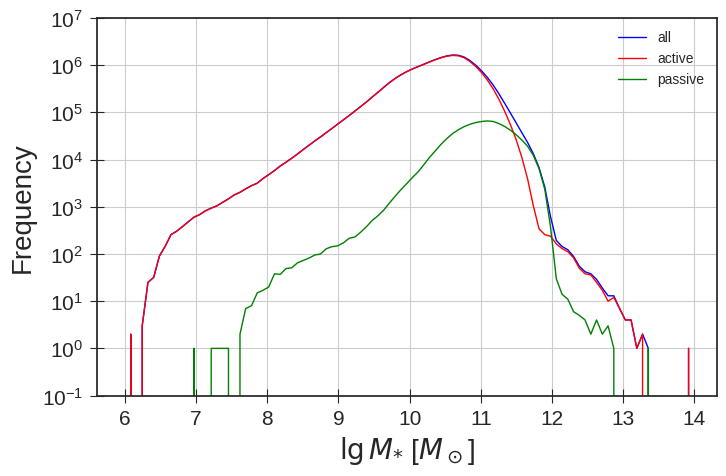

In [26]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(M_Kettlety), bins=np.linspace(6, 14, 100) )
plt.plot( bins[:-1], freq, lw = 1, color = 'blue', label = 'all' ) 
freq, bins = np.histogram( np.log10(M_Kettlety_active), bins=np.linspace(6, 14, 100) )
plt.plot( bins[:-1], freq, lw = 1, color = 'red', label = 'active' ) 
freq, bins = np.histogram( np.log10(M_Kettlety_passive), bins=np.linspace(6, 14, 100) )
plt.plot( bins[:-1], freq, lw = 1, color = 'green', label = 'passive' ) 
plt.legend()
plt.grid()

## Writting the stellar masses to the dataframe

In [27]:
data['SMass'] = M_Kettlety
Kettlety_err_corr = pd.concat( [Kettlety_err_corr_passive, Kettlety_err_corr_active] )
data['err_SMass'] = Kettlety_err_corr

print( 'Data with stellar masses:')
data

Data with stellar masses:


,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W1_err,z,flag,z_err,lumdis,lumdis_err,gal_type,num,SMass,err_SMass
0,NGC4736,NGC4736,12505314+4107125,J125053.14+410712.7,G,192.721451,41.120152,5.611000,NaN,0.000991,0.0,0.000029,4.392418,0.127479,1.0,0.0,NaN,NaN
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416000,NaN,0.004120,1.0,0.000119,15.876007,0.532731,1.0,1.0,3.357468e+09,1.566993e+09
2,NGC6503,NGC6503,17492651+7008396,J174926.45+700840.8,G,267.360474,70.144341,10.180000,NaN,0.001000,1.0,0.000029,12.446600,0.128670,1.0,2.0,NaN,NaN
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476000,NaN,0.003557,1.0,0.000103,11.461371,0.459550,0.0,3.0,6.801542e+09,9.432673e+08
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784000,NaN,0.004139,1.0,0.000120,15.180920,0.535217,1.0,4.0,2.187268e+09,1.021905e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23181753,NaN,NaN,NaN,NaN,Q,359.999118,28.954734,17.728901,NaN,2.452000,0.0,0.113916,20403.464630,1152.204222,NaN,NaN,NaN,NaN
23181754,NaN,NaN,NaN,NaN,Q,359.999303,34.720842,16.933657,NaN,3.109000,0.0,0.135597,27158.368406,1423.972156,NaN,NaN,NaN,NaN
23181755,NaN,NaN,NaN,NaN,Q,359.999615,3.268586,14.833991,NaN,1.232962,0.0,0.073688,8792.439985,652.241875,NaN,NaN,NaN,NaN
23181756,NaN,NaN,NaN,NaN,Q,359.999759,20.721079,16.979166,NaN,2.009865,0.0,0.099325,16022.500633,970.465889,NaN,NaN,NaN,NaN


### More histograms:

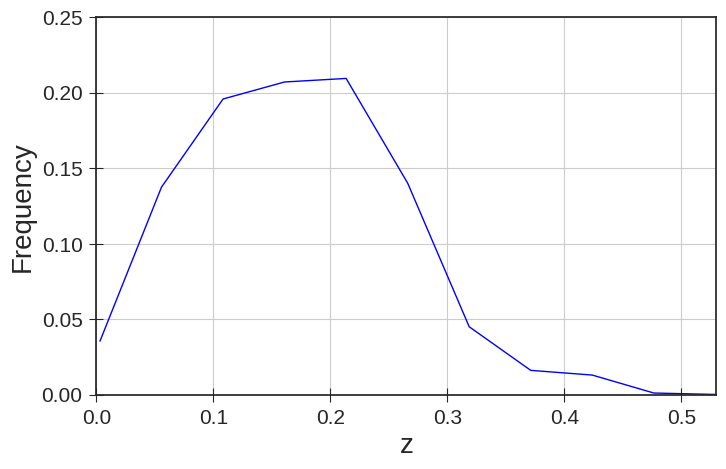

In [28]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.ylim(0,0.25)
plt.xlim(0,0.53)
plt.xlabel('z')
plt.ylabel( 'Frequency' )

# make and plot histograms:
freq, bins = np.histogram( data[~np.isnan(data.SMass)].z, bins=100 )
plt.plot( bins[:-1], freq/len(data[~np.isnan(data.SMass)]),  lw = 1, color = 'blue' )
plt.grid()

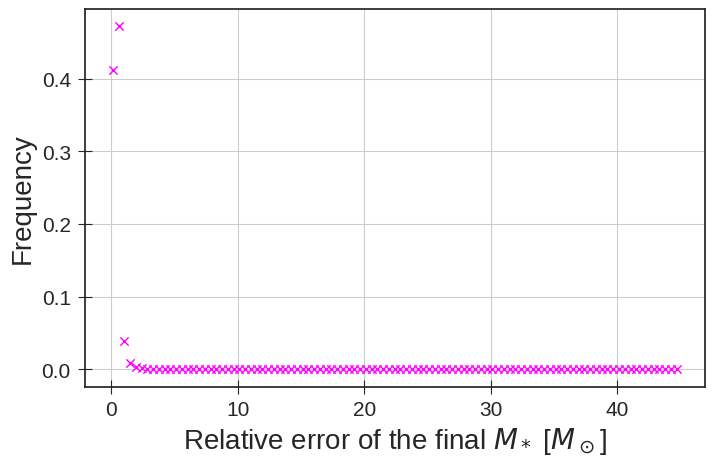

In [29]:
hist_form( 'Relative error of the final $M_*$ [$M_\odot$]', logscale=True )
plt.yscale( 'linear' )
plt.autoscale()

x = data.err_SMass/data.SMass
freq2, bins2 = np.histogram( x, bins = np.linspace( np.min(x), np.max(x), 100 ) )
plt.scatter( bins2[:-1],freq2/len(x),  
            marker = 'x', lw = 1, color = 'magenta', label = 'final' )

plt.grid()
#plt.legend( fontsize = 35 )

### Rounding the stellar masses

First we rounded the errors of stellar masses, then according to this we rounded the values of stellar masses.

In [31]:
data_finalmass = data[~np.isnan(data.SMass)]

In [32]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

# finding the order of the errors:
order_of_err = np.array([ orderOfMagnitude(i) for i in data_finalmass.err_SMass.values ])

errs = np.array( [ np.round( data_finalmass.err_SMass.values[i] / 10**order_of_err[i], 0 )
                  for i in range(data_finalmass.shape[0]) ] )

order_of_err[errs == 10] = order_of_err[errs == 10] + 1 
errs[errs == 10] = 1

# rounding
vals = np.array( [ np.round( data_finalmass.SMass.values[i] / 10**order_of_err[i], 0 ) 
                  for i in range(data_finalmass.shape[0]) ] )


# writing the results into the dataframe:
SMass_round = np.zeros( data.shape[0] )
np.add.at( SMass_round, data_finalmass.index, vals*10**order_of_err )

err_SMass_round = np.zeros( data.shape[0] )
np.add.at( err_SMass_round, data_finalmass.index, errs*10**order_of_err )

data['SMass_round'] = SMass_round
data['err_SMass_round'] = err_SMass_round

data.SMass_round.replace(0, np.nan, inplace=True)
data.err_SMass_round.replace(0, np.nan, inplace=True)

In [33]:
data[~np.isnan(data.SMass)]

,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W1_err,z,flag,z_err,lumdis,lumdis_err,gal_type,num,SMass,err_SMass,SMass_round,err_SMass_round
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416,NaN,0.004120,1.0,0.000119,15.876007,0.532731,1.0,1.0,3.357468e+09,1.566993e+09,3.000000e+09,2.000000e+09
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476,NaN,0.003557,1.0,0.000103,11.461371,0.459550,0.0,3.0,6.801542e+09,9.432673e+08,6.800000e+09,9.000000e+08
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784,NaN,0.004139,1.0,0.000120,15.180920,0.535217,1.0,4.0,2.187268e+09,1.021905e+09,2.000000e+09,1.000000e+09
5,NGC4586,NGC4586,12382843+0419087,J123828.39+041909,G,189.618484,4.319099,10.055,NaN,0.003320,1.0,0.000096,10.704358,0.428789,NaN,NaN,8.492456e+08,3.980622e+08,8.000000e+08,4.000000e+08
6,NGC4440,NGC4440,12275357+1217354,J122753.56+121735.8,G,186.973221,12.293191,9.872,NaN,0.004340,1.0,0.000126,18.027630,0.561461,0.0,6.0,4.641399e+09,6.005126e+08,4.600000e+09,6.000000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22431343,NaN,SDSSJ235402.72+201302.6,NaN,J235402.73+201302.6,G,358.511000,20.217400,14.902,0.034,0.308475,0.0,0.043180,1654.841013,271.557516,1.0,22177450.0,1.099255e+11,5.687785e+10,1.100000e+11,6.000000e+10
22431344,NaN,SDSSJ235200.81+201806.7,NaN,J235200.81+201806.7,G,358.003000,20.301880,14.153,0.029,0.200333,0.0,0.039611,1014.188600,227.806230,1.0,22177451.0,1.051526e+11,6.120263e+10,1.100000e+11,6.000000e+10
22431345,NaN,SDSSJ235232.35+201806.5,NaN,J235232.36+201806.2,G,358.135000,20.301830,14.678,0.033,0.201158,0.0,0.039638,1018.845712,228.136592,1.0,22177452.0,6.530593e+10,3.796107e+10,7.000000e+10,4.000000e+10
22431346,NaN,SDSSJ235039.56+201426,NaN,J235039.58+201425.6,G,357.665000,20.240560,14.686,0.032,0.356846,0.0,0.044776,1959.611688,291.331591,1.0,22177453.0,1.696497e+11,8.553034e+10,1.700000e+11,9.000000e+10


### The final form of the stellar mass:

The unit of stellar masses will be $10^{10} ~ M_\odot$.

In [34]:
data['SMass_final'] = data.SMass_round/1e10
data['err_SMass_final'] = data.err_SMass_round/1e10

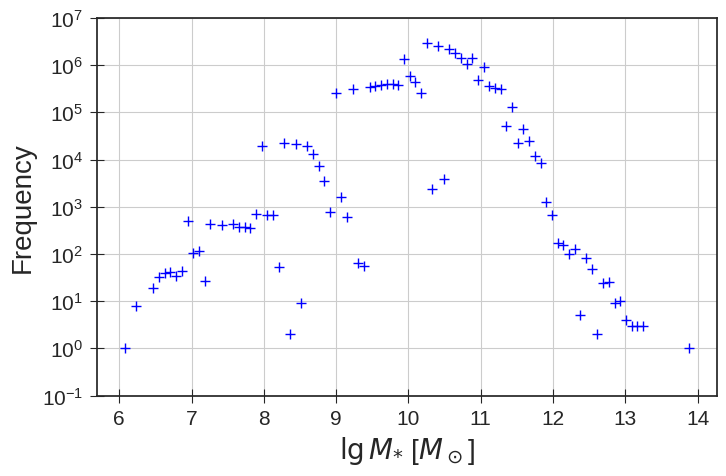

In [35]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass_final[~np.isnan(data.SMass_final)]*1e10), bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 1, s = 50, color = 'blue' ) 
plt.grid()
plt.savefig( 'sm_hist.eps', format = 'eps' ) #save the figure

The effect of the rounding:

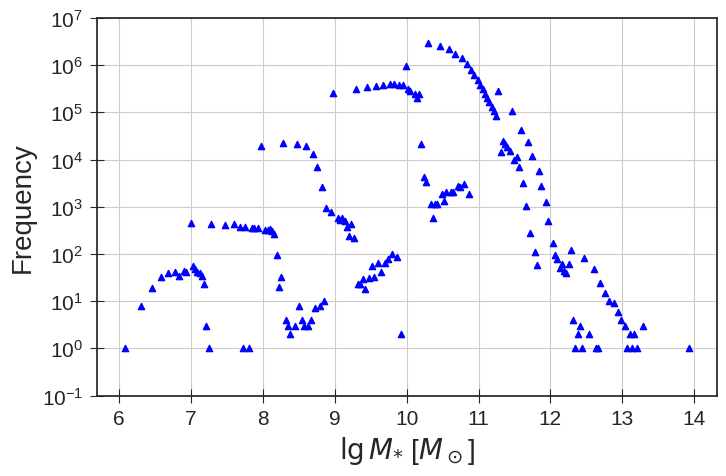

In [36]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass_final[~np.isnan(data.SMass_final)]*1e10), bins=250 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 20, color = 'blue' ) 

plt.grid()

Histogram of the relative error:

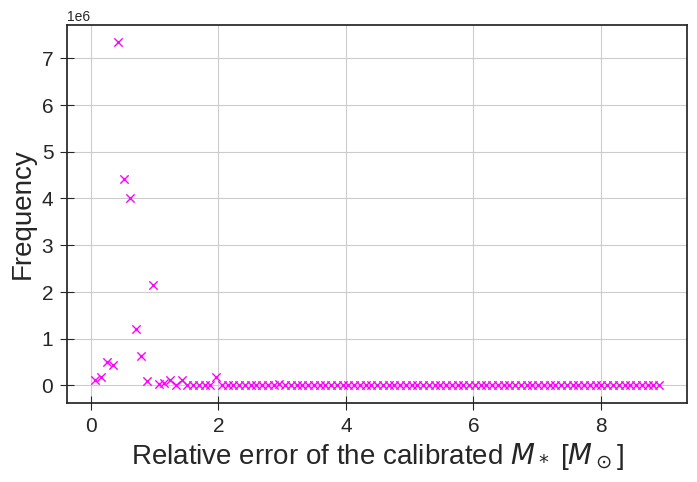

In [37]:
hist_form( 'Relative error of the calibrated $M_*$ [$M_\odot$]', logscale=True )
plt.yscale( 'linear' )
plt.autoscale()

x = data.err_SMass_final/data.SMass_final
freq2, bins2 = np.histogram( x, bins = np.linspace( np.min(x), np.max(x), 100 ) )
plt.scatter( bins2[:-1],freq2, marker = 'x', lw = 1, color = 'magenta' )

plt.grid()

The mean relative error:

In [38]:
np.mean(data.err_SMass_final/data.SMass_final)

0.6475543774817414

## Merger rates:

In the following section I give the merger rates of galaxies in three different scenario: the event of 2 black holes (DBH), two neutron stars (DNS) and a black hole and a neutron star (BHNS).

I use the results of Artale et al. MNRAS 487, 1675–1688 (2019)
 (Host galaxies of merging compact objects: mass, star
formation rate, metallicity and colours):

DNS: $$ \lg(n_{GW}/\text{Gyr}) = ( 1.15 \pm 0.08 ) \lg(M_*[M_{Sun}]) - ( 7.22 \pm 0.22 ), $$

DBH: $$ \lg(n_{GW}/\text{Gyr}) = ( 0.80 \pm 0.07 ) \lg(M_*[M_{Sun}]) - ( 4.14 \pm 0.19 ), $$

BHNS: $$ \lg(n_{GW}/\text{Gyr}) = ( 0.87 \pm 0.08 ) \lg(M_*[M_{Sun}]) - ( 4.99 \pm 0.22 ). $$

They studied the galaxies having stellar mass $M_* > 10^7 ~ M_\odot$ in the local universe $ z \leq 1$.

In [39]:
# find the data whose merger rate can be calculated:
print( 'We need the galaxies which have stellar masses larger than 10^7 and z <= 0.1' )
print('Shape before filtrations:', data.shape)
data_merger =  copy.deepcopy( data[ data.SMass > 10**7 ] )
print( 'Shape with stellar mass > 1e7:', data_merger.shape )
#data_merger =  data_merger[ data_merger.SMass_Kettlety < 10**13 ]  
#print( 'Shape with stellar mass < 1e13:', data_merger.shape )
data_merger = data_merger[ ~np.isnan(data_merger.z) ]  
print('Shape with known redshift:', data_merger.shape)
data_merger = data_merger[ data_merger.z <= 0.1 ]
print('Shape after redshift filtration:', data_merger.shape)
print( 'The shape of dataframe to which we can associate merger rates:' )
print( data_merger.shape )

# merger rate of BNS:
dns = 1.15 * np.log10( data_merger.SMass ) - 7.22
# error of merger rate of BNS:
err_dns = np.sqrt( ( np.log10(data_merger.SMass)*0.08 )**2 + 
                   ( 1.15*data_merger.err_SMass/(data_merger.SMass*np.log(10)) )**2 +
                   0.22**2 )

We need the galaxies which have stellar masses larger than 10^7 and z <= 0.1
Shape before filtrations: (23181758, 22)
Shape with stellar mass > 1e7: (21777404, 22)
Shape with known redshift: (21777404, 22)
Shape after redshift filtration: (3156544, 22)
The shape of dataframe to which we can associate merger rates:
(3156544, 22)


In [40]:
dns[:5], err_dns[:5]

(1    3.734914
 3    4.087498
 4    3.520887
 5    3.048388
 6    3.896646
 Name: SMass, dtype: float64,
 1    0.826742
 3    0.819726
 4    0.813108
 5    0.783236
 6    0.806609
 dtype: float64)

In [41]:
np.mean(err_dns/dns)

0.26549009525098716

Writing to the dataframe:

In [42]:
data['bns_rate'] = dns
data['err_dns_rate'] = err_dns

### Histograms of the merger rate (and comparision with the stellar mass):

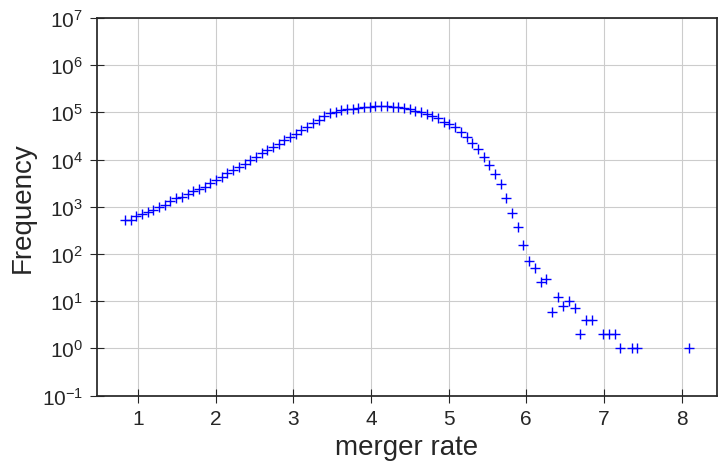

In [43]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)
plt.xlabel('merger rate')

# make and plot histograms:
freq, bins = np.histogram( dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

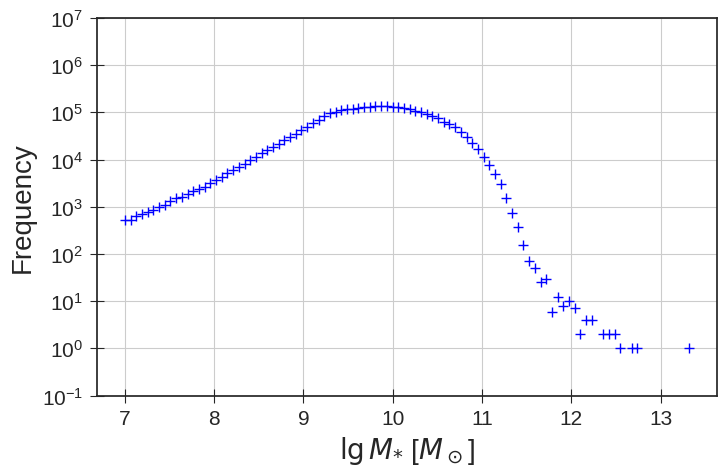

In [44]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data_merger.SMass), bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

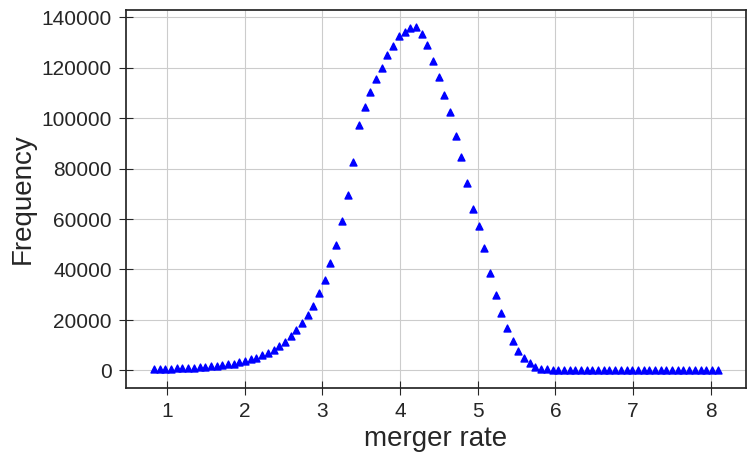

In [45]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.autoscale()
plt.xlabel('merger rate')

# make and plot histograms:
freq, bins = np.histogram( dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 25, color = 'blue' ) 

plt.grid()

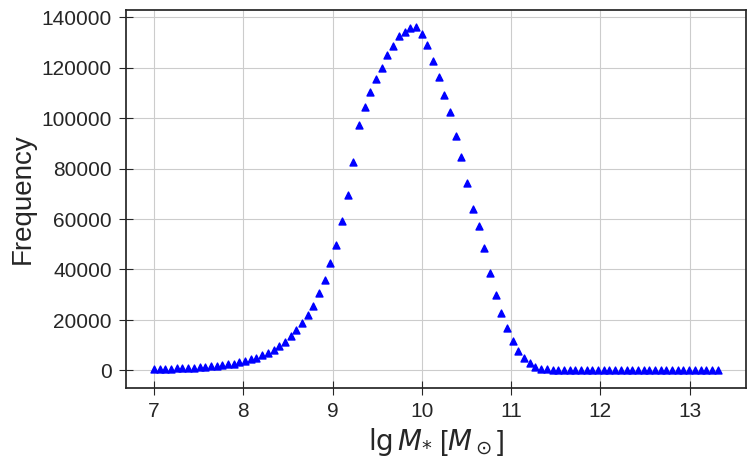

In [46]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.autoscale()

# make and plot histograms:
freq, bins = np.histogram( np.log10(data_merger.SMass), bins=100 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 25, color = 'blue' ) 

plt.grid()

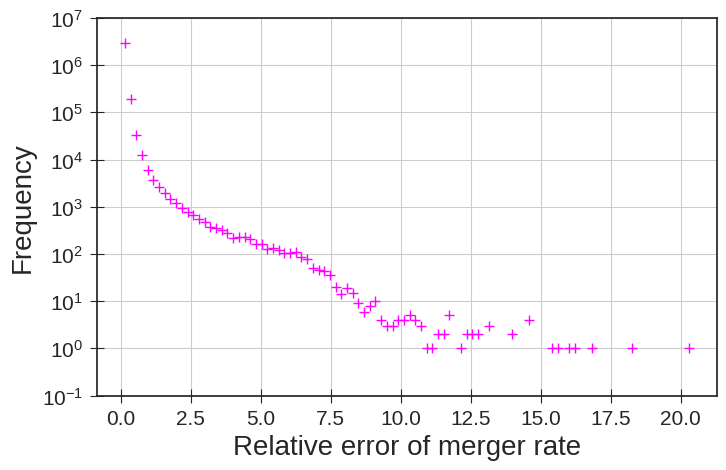

In [47]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)
plt.xlabel('Relative error of merger rate')

# make and plot histograms:
freq, bins = np.histogram( err_dns/dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 1, s = 50, color = 'magenta' ) 

plt.grid()

### Writing data to csv:

In [48]:
data.to_csv( 'original_columns_big.txt',
            columns = [ 'gal_type', 'SMass', 'err_SMass', 
                       'bns_rate', 'err_dns_rate' ],
            header=False, index=False )

Rounding the merger rate:

In [49]:
data['bns_rate_rounded'] = np.round(data.bns_rate, 1)
data['err_bns_rate_rounded'] = np.round(data.err_dns_rate, 1)

In [50]:
data[~np.isnan(data.bns_rate)]

,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W1_err,z,...,SMass,err_SMass,SMass_round,err_SMass_round,SMass_final,err_SMass_final,bns_rate,err_dns_rate,bns_rate_rounded,err_bns_rate_rounded
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416000,NaN,0.004120,...,3.357468e+09,1.566993e+09,3.000000e+09,2.000000e+09,0.30,0.20,3.734914,0.826742,3.7,0.8
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476000,NaN,0.003557,...,6.801542e+09,9.432673e+08,6.800000e+09,9.000000e+08,0.68,0.09,4.087498,0.819726,4.1,0.8
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784000,NaN,0.004139,...,2.187268e+09,1.021905e+09,2.000000e+09,1.000000e+09,0.20,0.10,3.520887,0.813108,3.5,0.8
5,NGC4586,NGC4586,12382843+0419087,J123828.39+041909,G,189.618484,4.319099,10.055000,NaN,0.003320,...,8.492456e+08,3.980622e+08,8.000000e+08,4.000000e+08,0.08,0.04,3.048388,0.783236,3.0,0.8
6,NGC4440,NGC4440,12275357+1217354,J122753.56+121735.8,G,186.973221,12.293191,9.872000,NaN,0.004340,...,4.641399e+09,6.005126e+08,4.600000e+09,6.000000e+08,0.46,0.06,3.896646,0.806609,3.9,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22430656,NaN,SDSSJ235636.99+010408.5,NaN,J235636.99+010409,G,359.154000,1.069020,15.659000,0.050,0.071254,...,3.900635e+09,4.189299e+09,4.000000e+09,4.000000e+09,0.40,0.40,3.809806,0.961696,3.8,1.0
22430814,ABELL2671:[SBM98]J2354+0522,ABELL2671:[SBM98]J2354+0522,NaN,J235442.78+052254.1,G,358.678000,5.381840,14.040000,0.028,0.010848,...,4.666588e+08,2.796180e+08,5.000000e+08,3.000000e+08,0.05,0.03,2.749349,0.786719,2.7,0.8
22430853,NaN,AGC335023,NaN,J235415.87+063405.6,G,358.566000,6.567780,16.058001,0.062,0.049403,...,1.318245e+09,1.942673e+09,1.000000e+09,2.000000e+09,0.10,0.20,3.267996,1.059449,3.3,1.1
22430891,NaN,AGC335024,NaN,J235507.69+074122.7,G,358.782000,7.689170,15.158000,0.038,0.039533,...,2.128566e+09,3.685834e+09,2.000000e+09,4.000000e+09,0.20,0.40,3.507300,1.163278,3.5,1.2


In [51]:
data.to_csv( 'to_GLADE_columns_big.txt',
            columns = [ 'gal_type', 'SMass_final', 'err_SMass_final', 
                       'bns_rate_rounded', 'err_bns_rate_rounded' ],
            header=False, index=False )